# 四大线性偏微分方程

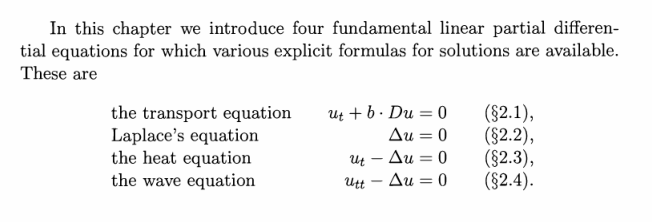

参考文献：

[1]Lawrence C. Evans.Partial Differential Equations,Second Edition[M].American Mathematical Society.2010.3.ISBN: 9780821849743


0. [绘图辅助函数](#Plot)
1. [输运方程(Transport equation)](#TransportEquation)
2. [拉普拉斯方程(Laplace's equation)](#LaplaceEquation)
3. [热方程(Heat equation)](#HeatEquation)
4. [波动方程(Wave Equation)](#WaveEquation)

# 运行版本

In [1]:
import sys

sys.version

'3.8.13 (default, Mar 28 2022, 06:59:08) [MSC v.1916 64 bit (AMD64)]'

In [2]:
import tensorflow

tensorflow.__version__

'2.6.0'

In [3]:
# !python -m deepxde.backend.set_default_backend tensorflow.compat.v1

In [4]:
import deepxde

deepxde.__version__

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



'1.1.3'

<a id="Plot"></a>
## 绘图辅助函数

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


def plot_loss_history(loss_history, figsize=(10, 8)):
    """Plot the training and testing loss history.

    Note:
        You need to call ``plt.show()`` to show the figure.

    Args:
        loss_history: ``LossHistory`` instance. The first variable returned from
            ``Model.train()``.
    """
    loss_train = np.sum(loss_history.loss_train, axis=1)
    loss_test = np.sum(loss_history.loss_test, axis=1)

    plt.figure(figsize=figsize)
    plt.semilogy(loss_history.steps, loss_train, label="Train loss")
    plt.semilogy(loss_history.steps, loss_test, label="Test loss")
    for i in range(len(loss_history.metrics_test[0])):
        plt.semilogy(
            loss_history.steps,
            np.array(loss_history.metrics_test)[:, i],
            label="Test metric",
        )
    plt.xlabel("Steps")
    plt.ylabel("loss")
    plt.legend()
    plt.show()
    

def _pack_data(train_state):
    def merge_values(values):
        if values is None:
            return None
        return np.hstack(values) if isinstance(values, (list, tuple)) else values

    y_train = merge_values(train_state.y_train)
    y_test = merge_values(train_state.y_test)
    best_y = merge_values(train_state.best_y)
    best_ystd = merge_values(train_state.best_ystd)
    return y_train, y_test, best_y, best_ystd

def plot_best_state(train_state, figsize=(10, 6)):
    """Plot the best result of the smallest training loss.

    This function only works for 1D and 2D problems. For other problems and to better
    customize the figure, use ``save_best_state()``.

    Note:
        You need to call ``plt.show()`` to show the figure.

    Args:
        train_state: ``TrainState`` instance. The second variable returned from
            ``Model.train()``.
    """
    if isinstance(train_state.X_train, (list, tuple)):
        print(
            "Error: The network has multiple inputs, and plotting such result han't been implemented."
        )
        return

    y_train, y_test, best_y, best_ystd = _pack_data(train_state)
    y_dim = best_y.shape[1]

    # Regression plot
    # 1D
    if train_state.X_test.shape[1] == 1:
        idx = np.argsort(train_state.X_test[:, 0])
        X = train_state.X_test[idx, 0]
        plt.figure(figsize=figsize)
        for i in range(y_dim):
            if y_train is not None:
                plt.plot(train_state.X_train[:, 0], y_train[:, i], "ok", label="Train")
            if y_test is not None:
                plt.plot(X, y_test[idx, i], "-k", label="True")
            plt.plot(X, best_y[idx, i], "--r", label="Prediction")
            if best_ystd is not None:
                plt.plot(
                    X, best_y[idx, i] + 2 * best_ystd[idx, i], "-b", label="95% CI"
                )
                plt.plot(X, best_y[idx, i] - 2 * best_ystd[idx, i], "-b")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
    # 2D
    elif train_state.X_test.shape[1] == 2:
        for i in range(y_dim):
            plt.figure(figsize=tuple([i*2 for i in figsize]))
            ax = plt.axes(projection=Axes3D.name)
            ax.plot3D(
                train_state.X_test[:, 0],
                train_state.X_test[:, 1],
                best_y[:, i],
                ".",
            )
            ax.set_xlabel("$x_1$")
            ax.set_ylabel("$x_2$")
            ax.set_zlabel("$y_{}$".format(i + 1))

    plt.show()


<a id="TransportEquation"></a>

## 1 输运方程(Transport equation)

下面记 $u = u(x,t), x=(x_1,\cdots,x_n) \in \mathbb{R}^n, t \geq 0$ ，$x$ 是空间中的一个点，$t$ 是时间。$Du = D_x u = (u_{x_1},\cdots,u_{x_n})$是代表 $u$ 关于空间变量 $x$ 的梯度。$u_t$ 代表 $u$ 关于时间的偏导数。

**定义1.1** 偏微分方程
$$
\large u_t + b \cdot D_u = 0,(x,t) \in \mathbb{R}^n \times (0,\infty)    \tag{1}
$$
是**输运方程(transport equation)**，这里 $b=(b_1,\cdots,b_n) \in \mathbb{R}^n$ 是个固定的向量。

为了解这个PDE，我们现在就不妨设 $u$ 有某个光滑的解然后再尝试计算它。首先注意到方程(1)表明 $u$ 的某个特定方向的导数为0, 我们固定任意的点 $(x,t) \in \mathbb{R}^n \times (0,\infty)$ 并定义 $\large z(s) \triangleq u(x+sb,t+s) s \in \mathbb{R}$，

以下都记 $\frac {d} {ds} = \dot{} $，利用方程(1)计算得到 $\large \dot z(s) = Du(x+sb,t+s) · b + u_t(x+sb,t+s) = 0$。

因此 $z(·{})$ 是关于 $s$ 的常函数，所以对每个点 $(x,t)$，$u$ 在穿过 $(x,t)$ 且方向是 $(b,1) \in \mathbb{R}^{n+1}$ 的直线(记为 $l$ )上是个常数。因此，如果我们知道了直线 $l$ 上任意一个点的 $u$ 值，我们就知道了这条直线 $l$ 的值。

### 1.1 初值问题

为了确定所需要的解, 考虑如下初值问题
$$
\large
\begin{cases}
\begin{aligned}
u_t+b· D_u &= 0, in \ \mathbb{R}^n \times (0,\infty) \\ 
u &= g, on \ \mathbb{R}^n \times \{t=0\}.  \\ 
\end{aligned}
\end{cases} 
\tag{2}
$$
这里 $b \in \mathbb{R}^n,g:\mathbb{R}^n \to \mathbb{R}$ 给定, 现在要求出 $u$ 的表达式。

固定了上述 $(x,t)$，穿过 $(x,t)$ 且方向为 $(b,1)$ 的直线可以用参数方程 $(x+sb,t+s) (s \in \mathbb{R})$ 表示，当 $s=-t$ 时，这条直线打在平面$\Gamma := \mathbb{R}^n \times \{t=0\}$ 上，且交点是 $(x-tb,0)$。由于 $u$ 是直线上的常数，且 $u(x-tb,0)=g(x-tb)$，因此
$$
\large u(x,t) = g(x-tb),x \in \mathbb{R}^n,t \geq 0.\tag{3}
$$
因此如果方程(2)有足够好的解 $u$，则这个解一定形如(3)。另一方面，容易判断如果$g \in C^1$，则式(3)满足方程(2)。

**注:** 如果 $g \not \in C^1$，显然方程(2)没有解 $C^1$，则这个解叫做“**弱解**”。不过有时候不光滑甚至是不连续的函数都可以作为PDE的一个弱解。

### 1.2 非齐次初值问题

下面考虑非齐次方程
$$
\large
\begin{cases}
\begin{aligned}
u_t+b · D_u &= f, in \ \mathbb{R}^n \times (0,\infty) \\ 
u &= g, on \ \mathbb{R}^n \times \{t=0\}.  \\ 
\end{aligned}
\end{cases}
\tag{4}
$$
受前面过程启发，我们与前面类似，固定 $(x,t) \in \mathbb{R}^{n+1}$，记 $\large z(s) \triangleq u(x+sb,t+s) s \in \mathbb{R}$，则$\large \dot z(s) = Du(x+sb,t+s) · b + u_t(x+sb,t+s) = f(x+sb,t+s)$。

因此
$$
\large
\begin{align*}
u(x,t) - g(x-tb) &= z(0) - z(-t) = \int^0_{-t} \dot{z}(s) ds \\
&= \int^0_{-t} f(x+sb,t+s) ds   \\ 
&= \int^t_{0} f(x+(s-t)b,s) ds,   \\
\end{align*}
$$
因此 $\large u(x,t) = g(x-tb) + \int^t_{0} f(x+(s-t)b,s) ds, x\in \mathbb{R}^n,t \geq 0$是初值问题(4)的解。这个方程可以被用来解一维的波动方程。

**注：**注意到我们实际上是通过有效地把PDE转变成ODE最终得到PDE的解，这些步骤是“**特性曲线法**”的一种特例。

### 问题设置
下面考虑非齐次方程
$$
\large
\begin{cases}
\begin{aligned}
u_t+2 · D_u &= x, in \ \mathbb{R}^1 \times (0,\infty) \\ 
u &= x^2, on \ \mathbb{R}^1 \times \{t=0\}.  \\ 
\end{aligned}
\end{cases}
$$

当我们用DeepXDE求解上式时，应该改写为
$$\large u_t+2 · u_x = x, x \in [−1,1], t \in [0,1]$$

初始条件 $\large u(x,0) = x^2, $ 


使用mathematica来求解

```mathematica
sol = DSolve[{D[u[t, x], t] + 2*D[u[t, x], x] == x, u[0, x] == x^2}, 
   u[t, x], {t, x}];
TraditionalForm[u[t, x] /. sol[[1]]]
```

得到的答案为：$\large u(x,t) = 3t^2-3tx+x^2$ 。

可以在 wolframalpha 网站查看图像。

https://www.wolframalpha.com/input?i=plot+u%28x%2Cy%29%3D3*y%5E2%E2%88%923*x*y%2Bx%5E2%2C+x%3D-1+to+1%2C+y%3D0+to+1

#### 参考代码：
https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/burgers.html

### 执行

本描述逐步介绍了上述transport equation的求解器的实现。

首先，导入 DeepXDE 和 TensorFlow ( `tf`) 模块：

In [2]:
import deepxde as dde
from deepxde.backend import tf

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



transport 方程：

$\large u_t+2 · u_x = x, x \in [−1,1], t \in [0,1]$


我们首先定义一个计算几何和时域。我们可以使用内置类`Interval`，并且我们使用以下方式`TimeDomain`组合两个域`GeometryXTime`

In [3]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [4]:
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    return dy_t + 2 * dy_x - x[:, 0:1]

接下来，我们考虑边界/初始条件。

初始条件 $\large u(x,0) = x^2, $ 

In [5]:
ic = dde.icbc.IC(geomtime, lambda x: x[:, 0:1]**2, lambda _, on_initial: on_initial)

解为：$\large u(x,t) = 3t^2-3tx+x^2$ 

In [6]:
def func(x):
    return 3*x[:, 1:]**2 - 3*x[:, 1:]*x[:, 0:1] + x[:, 0:1]**2

现在，我们已经指定了几何、PDE 残差和边界/初始条件。然后我们将`TimePDE`问题定义为

In [7]:
data = dde.data.TimePDE(geomtime, pde, [ic],
                        num_domain=2540, num_boundary=80, num_initial=160,
                        solution=func,num_test=10000,)

G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


数字 2540 是在域内采样的训练残差点数，数字 80 是在边界上采样的训练点数。我们还包括初始条件的 160 个初始残差点。

接下来，我们选择网络。在这里，我们使用深度为 4（即 3 个隐藏层）和宽度为 20 的全连接神经网络：

In [8]:
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

现在，我们有 PDE 问题和网络。我们构建一个`Model`并选择优化器和学习率：

In [9]:
model = dde.Model(data, net)
model.compile("adam", lr=2e-4)

Compiling model...
Building feed-forward neural network...
'build' took 0.058775 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.282489 s



然后我们训练模型进行 10000 次迭代：

In [10]:
losshistory, train_state = model.train(epochs=10000)

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.04e+00, 3.19e-01]    [1.03e+00, 3.19e-01]    []  
1000      [1.27e-02, 4.29e-02]    [1.05e-02, 4.29e-02]    []  
2000      [9.04e-03, 2.96e-02]    [8.11e-03, 2.96e-02]    []  
3000      [5.57e-03, 4.55e-03]    [4.94e-03, 4.55e-03]    []  
4000      [1.36e-03, 1.31e-03]    [1.17e-03, 1.31e-03]    []  
5000      [3.49e-04, 5.27e-04]    [2.88e-04, 5.27e-04]    []  
6000      [9.79e-05, 1.66e-04]    [7.72e-05, 1.66e-04]    []  
7000      [6.00e-05, 4.23e-05]    [4.83e-05, 4.23e-05]    []  
8000      [4.49e-05, 1.35e-05]    [3.73e-05, 1.35e-05]    []  
9000      [3.34e-05, 6.60e-06]    [2.78e-05, 6.60e-06]    []  
10000     [3.03e-05, 6.01e-06]    [2.60e-05, 6.01e-06]    []  

Best model at step 10000:
  train loss: 3.63e-05
  test loss: 3.20e-05
  test metric: []

'train' took 20.459453 s



在我们使用 Adam 训练网络之后，我们继续使用 L-BFGS 训练网络以实现更小的损失：

In [11]:
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.120933 s

Training model...

Step      Train loss              Test loss               Test metric
10000     [3.03e-05, 6.01e-06]    [2.60e-05, 6.01e-06]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000000
  Number of iterations: 681
  Number of functions evaluations: 771
10771     [7.69e-08, 2.79e-08]    [5.10e-08, 2.79e-08]    []  

Best model at step 10771:
  train loss: 1.05e-07
  test loss: 7.89e-08
  test metric: []

'train' took 3.382341 s



saveplot

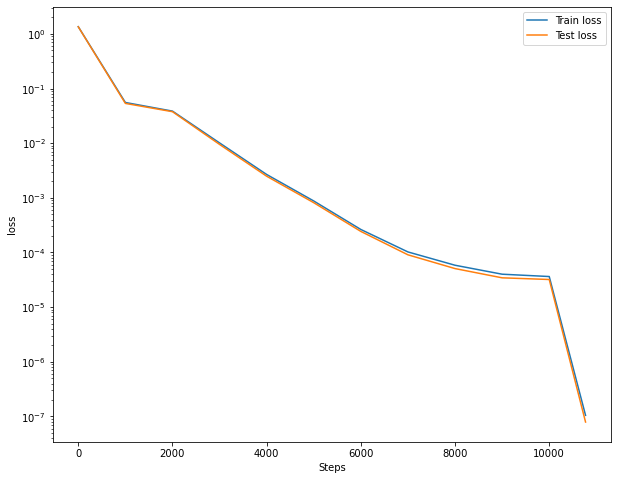

In [12]:
plot_loss_history(losshistory)

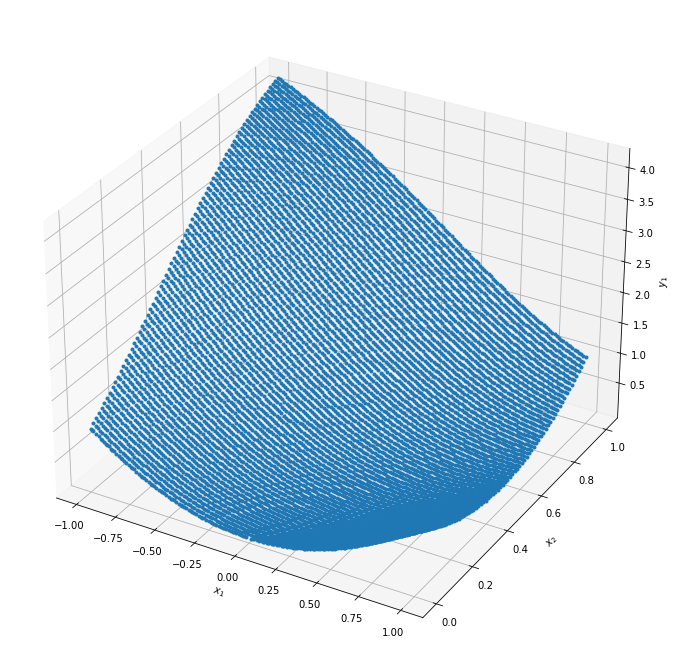

In [13]:
plot_best_state(train_state)

<a id="LaplaceEquation"></a>
## 2 拉普拉斯方程(Laplace's equation)

本节介绍Laplace方程的定义以及它的基本解。



### 2.1 基本定义

记 $\large x=(x_1,\cdots,x_n) \in \mathbb{R}^n, u=u(x), 拉普拉斯算子 \Delta u = \sum^n_{i=1} u_{x_i x_i} $，Laplace方程又称为“**位势方程**”, 最有用的PDE之一无疑。包括Laplace方程
$$
\large \Delta u = 0 \tag{2.1}
$$
以及Poisson方程
$$
\large - \Delta u = f.  \tag{2.2}
$$
在上面两个方程中，$x \in U$ 且未知量为 $\large u:\bar{U} \to \mathbb{R}, u = u(x)$，这里 $u \subset \mathbb{R}^n$ 是开集. 而在第二个方程中 $f:U \to \mathbb{R}$ 也是给定的。

**定义2.1[调和函数]** 假设$u \in C^2$ 且满足 $\Delta u = 0$，则称 $u$ 为调和函数。



### 2.2 基本解

基本解(fundamental solution)的来源: 研究PDE的一个好的方式是去找某个特解. 由于这个PDE是线性的, 所以可以用特解去找更复杂的解. 此外, 为了寻找显然的特解, 通常会把注意力集中在某类具有**对称性**的函数.

**定义2.2** 函数
$$
\large
\Phi(x) = 
\begin{cases}
\begin{aligned}
&-\frac{1}{2\pi} \ln|x|, & n=2\\
&\frac{1}{n(n-2)\alpha(n)}   \frac{1}{|x|^{n-2}}, & n\geq3\\
\end{aligned}
\end{cases}
(x \in \mathbb{R}^n, x \neq 0) \tag{2.3} \\
$$
叫做Laplace方程的**基本解**，这里 $\large \alpha(n) = \mathbb{R}^n中单位球的体积 = \frac{\sqrt{\pi^n}}{ \Gamma(\frac{n}{2}+1)}$。

### 问题设置2.1
#### 磁盘上的拉普拉斯方程
我们将在极坐标系中求解拉普拉斯方程：

$$r\frac{dy}{dr}+r^2\frac{dy}{dr^2}+\frac{dy}{dθ^2}=0,r∈[0,1],θ∈[0,2π]$$
与狄利克雷边界条件

$$y(1,θ)=cos(θ)$$
和周期性边界条件

$$y(r,θ+2π)=y(r,θ).$$
参考解决方案是 $y=rcos(θ)$.

#### 代码来源
https://deepxde.readthedocs.io/en/latest/demos/laplace.disk.html

导入模块

In [2]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



**定义PDE 问题**

拉普拉斯方程：

$$r\frac{dy}{dr}+r^2\frac{dy}{dr^2}+\frac{dy}{dθ^2}=0,r∈[0,1],θ∈[0,2π]$$

In [3]:
def pde(x, y):
    dy_r = dde.grad.jacobian(y, x, i=0, j=0)
    dy_rr = dde.grad.hessian(y, x, i=0, j=0)
    dy_thetatheta = dde.grad.hessian(y, x, i=1, j=1)
    return x[:, 0:1] * dy_r + x[:, 0:1] ** 2 * dy_rr + dy_thetatheta

In [4]:
# Rectangle 𝑟∈[0,1],θ∈[0,2π]

geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 2 * np.pi])

狄利克雷边界条件

$$y(1,θ)=cos(θ)$$
和周期性边界条件

$$y(r,θ+2π)=y(r,θ).$$

In [5]:
def boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

bc_rad = dde.DirichletBC(
    geom,
    lambda x: np.cos(x[:, 1:2]),
    lambda x, on_boundary: on_boundary and np.isclose(x[0], 1),
)

方程的解是 $y=rcos(θ)$.

In [6]:
def solution(x):
    r, theta = x[:, 0:1], x[:, 1:]
    return r * np.cos(theta)

定义PDE问题

In [7]:
data = dde.data.PDE(
    geom, pde, bc_rad, num_domain=2540, num_boundary=80,
    solution=solution, num_test=10000,
)
# 数字 2540 是在域内采样的训练残差点数，数字 80 是在边界上采样的训练点数。

G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+84=84. 
  warnings.warn("The balance properties of Sobol' points require "


定义net

In [8]:
# 如果我们用笛卡尔坐标重写这个问题，变量的形式为[rsin(θ),rcos(θ)]. 
# 我们将它们用作特征来满足某些潜在的物理约束，从而使网络沿θ坐标，周期为2π.

def feature_transform(x):
    return tf.concat(
        [x[:, 0:1] * tf.sin(x[:, 1:2]), x[:, 0:1] * tf.cos(x[:, 1:2])], axis=1
    )

In [9]:
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot normal")

net.apply_feature_transform(feature_transform)

定义model

In [10]:
model = dde.Model(data, net)
model.compile("adam", lr=2e-5, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.071279 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.614380 s



model.train

In [11]:
losshistory, train_state = model.train(epochs=30000)

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [3.72e-05, 4.93e-01]    [3.39e-05, 4.93e-01]    [9.95e-01]    
1000      [1.44e-02, 9.86e-04]    [1.29e-02, 9.86e-04]    [2.62e-02]    
2000      [5.77e-03, 3.49e-04]    [5.08e-03, 3.49e-04]    [1.63e-02]    
3000      [1.30e-03, 7.69e-05]    [1.09e-03, 7.69e-05]    [8.16e-03]    
4000      [2.23e-04, 1.37e-05]    [1.71e-04, 1.37e-05]    [5.31e-03]    
5000      [1.31e-04, 7.27e-06]    [1.06e-04, 7.27e-06]    [4.92e-03]    
6000      [8.33e-05, 4.77e-06]    [6.82e-05, 4.77e-06]    [4.38e-03]    
7000      [5.58e-05, 5.63e-06]    [4.60e-05, 5.63e-06]    [4.06e-03]    
8000      [4.13e-05, 6.36e-06]    [3.42e-05, 6.36e-06]    [3.78e-03]    
9000      [3.12e-05, 5.07e-06]    [2.59e-05, 5.07e-06]    [3.29e-03]    
10000     [2.25e-05, 3.05e-06]    [1.87e-05, 3.05e-06]    [2.68e-03]    
11000     [1.46e-05, 1.40e-06]    [1.21e-05, 1.40e-06]    [2.03e-03]    
12000 

绘制图像

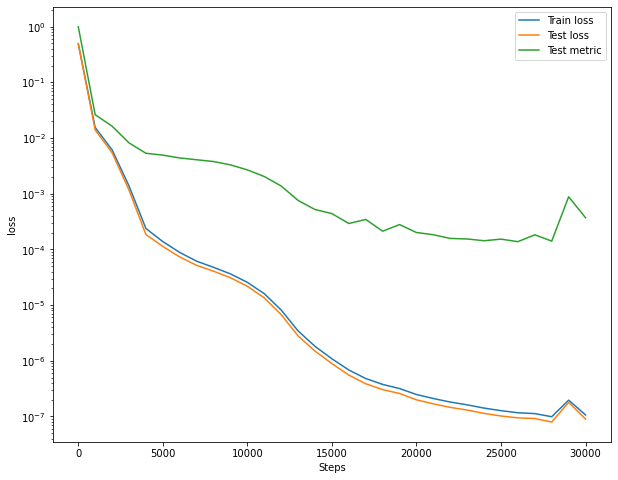

In [12]:
plot_loss_history(losshistory)

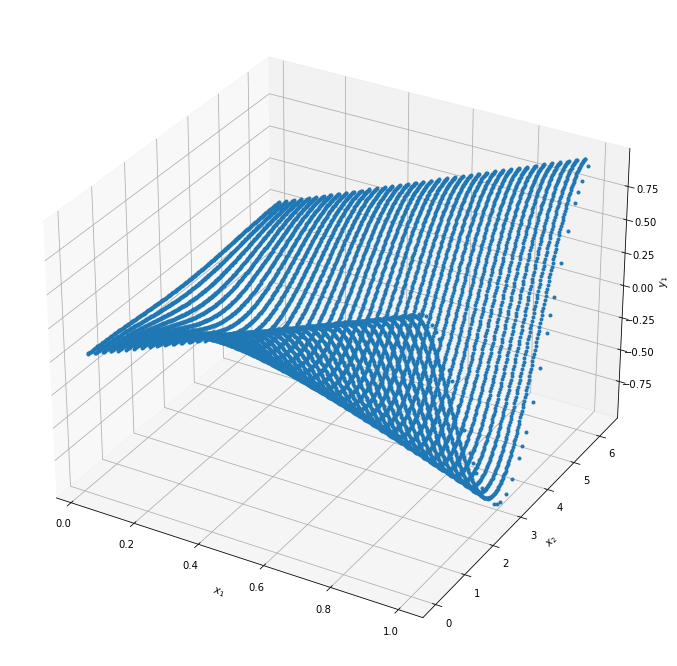

In [13]:
plot_best_state(train_state)


### 问题设置2.2
- 具有狄利克雷/周期边界条件的一维泊松方程

我们将求解一个泊松方程：$$\large −Δu=π^2sin(πx),x∈[−1,1], \tag{2.3}$$

在右边界上具有周期性边界条件: $\large u(0)=u(1).$

和左边界上的狄利克雷边界条件: $\large u(−1)=0.$ 

确切的解决方案是 $$\large u(x)=sin(πx).$$ 

mathematica求解代码
```mathematica
DSolve[{-D[u[x], {x, 2}] == Pi^2 Sin[Pi x], u[0] == u[1], u[-1] == 0}, u[x], {x}]
```

#### 代码来源
https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/poisson.1d.dirichletperiodic.html

In [2]:
# 首先，导入 DeepXDE 和 TensorFlow ( `tf`) 模块：

import deepxde as dde
import numpy as np
from deepxde.backend import tf

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



定义泊松方程：$\large −Δu=π^2sin(πx),x∈[−1,1]$

In [3]:
# 几何区域
geom = dde.geometry.Interval(-1, 1)


# 偏微分方程
def pde(x, y):
    """
    x: network input,  x-coordinate
    y: network output, the solution u(x),but here we use y as the name of the variable.
    return: −Δ𝑢 -π^2 𝑠𝑖𝑛(π𝑥)
    """
    dy_xx = dde.grad.hessian(y, x)
    return -dy_xx - np.pi ** 2 * tf.sin(np.pi * x)

定义边界条件

在右边界上具有周期性边界条件: $u(0)=u(1).$

和左边界上的狄利克雷边界条件: $u(−1)=0.$

In [4]:
def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], -1)

# define a function to return the value of u(x) for the points x on the Dirichlet boundary.
def func(x):
    return np.sin(np.pi * x)


# 狄利克雷边界条件
bc1 = dde.DirichletBC(geom, func, boundary_l) 
# 周期性边界条件
bc2 = dde.PeriodicBC(geom, 0, boundary_r) 

In [5]:
data = dde.data.PDE(geom, pde, [bc1, bc2], 16, 2, solution=func, num_test=100)

# 数字 16 是在域内采样的训练残差点数，数字 2 是在边界上采样的训练点数。
# 参数`solution=func`是计算我们解决方案误差的参考解决方案，如果我们没有参考解决方案，可以忽略。
# 我们使用 100 个残差点来测试 PDE 残差。

G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+18=18. 
  warnings.warn("The balance properties of Sobol' points require "


net

In [6]:
# 深度为 4（即 3 个隐藏层）和宽度为 50 的全连接神经网络
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model

构建一个`Model`并选择优化器和学习率,L2相对误差作为训练期间的指标

In [7]:
model = dde.Model(data, net)
model.compile("adam", lr=2e-5, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.062348 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.429689 s



model.train

In [8]:
losshistory, train_state = model.train(epochs=80000)

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [4.55e+01, 1.09e-01, 4.36e-01]    [4.80e+01, 1.09e-01, 4.36e-01]    [7.98e-01]    
1000      [1.62e+01, 6.96e-03, 6.08e-01]    [1.72e+01, 6.96e-03, 6.08e-01]    [6.38e-01]    
2000      [7.04e+00, 2.22e-04, 3.39e-01]    [7.16e+00, 2.22e-04, 3.39e-01]    [4.69e-01]    
3000      [2.33e+00, 2.41e-04, 5.14e-02]    [2.11e+00, 2.41e-04, 5.14e-02]    [1.60e-01]    
4000      [6.78e-01, 1.29e-05, 1.93e-03]    [3.77e-01, 1.29e-05, 1.93e-03]    [6.16e-02]    
5000      [3.96e-01, 7.81e-05, 1.53e-03]    [2.00e-01, 7.81e-05, 1.53e-03]    [4.48e-02]    
6000      [1.81e-01, 5.91e-05, 5.98e-04]    [7.66e-02, 5.91e-05, 5.98e-04]    [3.30e-02]    
7000      [7.31e-02, 4.41e-06, 1.61e-04]    [3.40e-02, 4.41e-06, 1.61e-04]    [2.05e-02]    
8000      [2.51e-02, 1.15e-06, 4.89e-05]    [1.23e-02, 1.15e-06, 4.89e-05]    [1.11e-02]    
9000      [7.73e-03, 8.09

plot

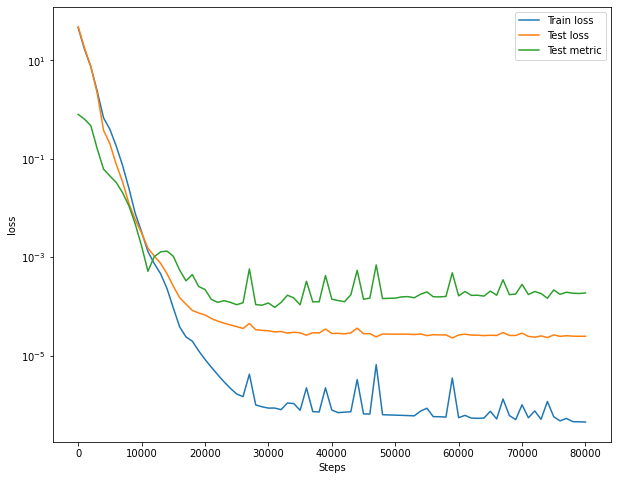

In [9]:
plot_loss_history(losshistory)

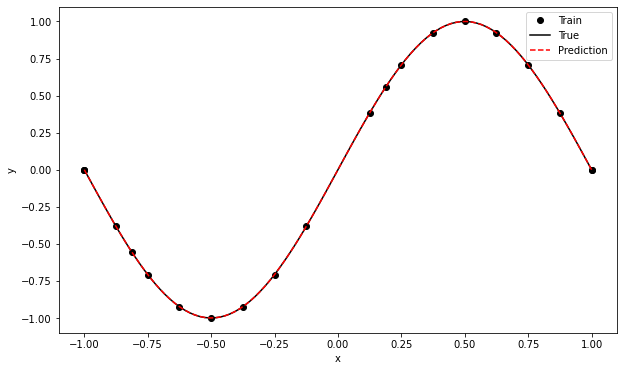

In [10]:
plot_best_state(train_state)

<a id="HeatEquation"></a>
## 3 热方程(Heat equation)

"热像引力一样穿透宇宙所有物质，辐射整个空间“。                                

​																									——傅立叶《热分析理论》1822


### 3.1 什么是热传导方程

热传导方程(heat equation)
$$
\large u_t - \Delta u = 0,  \tag{3.1}
$$
以及非齐次热传导方程
$$
\large u_t - \Delta u = f.  \tag{3.2}
$$
其中给定合适的初值与边界条件. 这里 $t>0,x\in U \subset \mathbb{R}^n$ 为开集. 不确定的东西是 $\large u:\bar{U} \times[0,\infty) \to \mathbb{R}, u = u(x,t)$，而Laplace算子是关于空间 $x=(x_1,\cdots,x_n)$ 的, 即 $\Delta u = \Delta_x u = \sum^n_{i=1} u_{x_i x_i}$ 在非齐次的方程中 $f:U\times[0,\infty) \to \mathbb{R}$ 是给定的.



### 3.2 基本解

**定义3.1 [热传导方程的基本解]** 定义函数
$$
\large
\Phi(x,t) \triangleq 
\begin{cases}
\begin{aligned}
&\frac{1}{(4\pi t)^{n/2}} e^{-\frac{|x|^2}{4t}}, & x \in \mathbb{R}^n, t > 0\\
&0, & x \in \mathbb{R}^n, t \leq 0\\
\end{aligned}
\end{cases}
\tag{3.3} \\
$$
为热传导方程的基本解。



### 3.3 齐次初值问题

下面用 $\Phi(x,t) $ 来解下面的初值(Cauchy)PDE:
$$
\large
\begin{cases}
\begin{aligned}
u_{t}-\Delta u &= 0, in \ \mathbb{R}^n \times (0,\infty) \\ 
u &= g, on \ \mathbb{R}^n \times \{t=0\}.  \\ 
\end{aligned}
\end{cases} 
\tag{3,4}
$$

仿照Laplace方程的过程, 如果我们作一个卷积
$$
\large
\begin{align}
u(x,t) &= \int_{\mathbb{R}^n} \Phi(x-y,t)g(y)dy\\
       &= \frac{1}{(4\pi t)^{n/2}} \int_{\mathbb{R}^n} e^{-\frac{|x-y|^2}{4t}}g(y)dy(x\in \mathbb{R}^n,t>0) \\
\tag{3.5}
\end{align}
$$
**定理1.2 [初值问题的解]** 设 $\large g \in C(\mathbb{R}^n) \cap L^{\infty}(\mathbb{R}^n)$，定义 $u$ 如式(3.5)，则

（1） $\large u\in C^{\infty}(\mathbb{R}^n \times (0,\infty))$，

（2）$\large u_t(x,t)-\Delta u(x,t) = 0, (x\in \mathbb{R}^n,t>0)$，

（3）$\large \lim_{(x,t)\to (x^0,0)} u(x,t) = g(x^0), \forall x^0 \in \mathbb{R}^n, 这里x\in \mathbb{R}^n, t>0$。

### 3.4 非齐次问题

下面考虑非齐次问题
$$
\large
\begin{cases}
\begin{aligned}
u_{t}-\Delta u &= f, in \ \mathbb{R}^n \times (0,\infty) \\ 
u &= 0, on \ \mathbb{R}^n \times \{t=0\}.  \\ 
\end{aligned}
\end{cases} 
\tag{3,6}
$$

$$
\large
\begin{align*}
u(x,t) &= \int^t_0 u(x,t;s)ds \\
       &= \int^t_0 \int_{\mathbb{R}^n} \Phi(x-y,t-s)f(y,s)dyds \\
       &= \int^t_0 \frac{1}{(4\pi (t-s))^{n/2}} \int_{\mathbb{R}^n} e^{-\frac{|x-y|^2}{4(t-s)}}f(y,s)dyds,\\
\tag{3.7}
\end{align*}
$$

**定理1.3 [非齐次问题的解]** 定义 $u$ 如式(3.7), 则

（1） $\large u\in C^2_1(\mathbb{R}^n \times (0,\infty))$，

（2）$\large u_t(x,t)-\Delta u(x,t) = f(x,t), (x\in \mathbb{R}^n,t>0)$，

（3）$\large \lim_{(x,t)\to (x^0,0)} u(x,t) = 0, \forall x^0 \in \mathbb{R}^n, 这里x\in \mathbb{R}^n, t>0$。



### 问题设置
在本代码中，我们将使用 DeepXDE 库中的 PINN 来求解热方程(heat equation)。

热方程的形式如下:
$$\large \frac{\partial u}{\partial t} = \alpha \nabla^2 u\;$$ .

其中 $\nabla^2$ 是拉普拉斯微分算子，$\alpha$ 是热扩散率常数，$u$ 是我们要近似的函数(温度)。

在一维情况下，我们有:$$\large \frac{\partial u(x, t)}{\partial t} = \alpha \frac{\partial^2u(x,t)}{{\partial x}^2}\;, \;\;\;\; x \in [0, 1]\;, \;\;\;\; t \in [0, 1]\;$$.

具有 Dirichlet 边界条件: $$\large u(0, t) = u(1, t) = 0\;$$ , 

和周期性(sinoidal)初始条件: $$\large u(x, 0) = sin(n\pi x/L)\;, \;\;\;\; 0 < x < L\;, \;\;\;\; n = 1, 2, ...\;.$$

这种设置是许多微分方程教科书中常见的问题，可以被物理解释为均匀一维杆中温度随时间的变化。在这里，常量 $\alpha$ 是热扩散率(棒的材料属性) ，$L$ 是棒的长度。

方程的解为：$$\large u(x,t) = e^{\frac{-n^2 \pi^2 a t}{L^2}} \sin(\frac{n \pi x}{L}) .$$

#### 代码来源
https://github.com/lululxvi/deepxde/blob/master/examples/pinn_forward/heat_conduction_1d_uniform_bar.ipynb

In [2]:
# Import libraries:
import matplotlib.pyplot as plt
import numpy as np

import deepxde as dde
from deepxde.backend import tf

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [3]:
def heat_eq_exact_solution(x, t):
    """
    Returns the exact solution for a given x and t (for sinusoidal initial conditions).
    
    Parameters
    ----------
    x : np.ndarray
    t : np.ndarray
    """
    
    return np.exp(-(n**2*np.pi**2*a*t)/(L**2))*np.sin(n*np.pi*x/L)

def gen_exact_solution():
    """
    Generates exact solution for the heat equation for the given values of x and t.
    """
    
    # Number of points in each dimension:
    x_dim, t_dim = (256, 201)

    # Bounds of 'x' and 't':
    x_min, t_min = (0, 0.)
    x_max, t_max = (L, 1.)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i],t[j])

    # Save solution:
    np.savez('heat_eq_data', x=x, t=t, usol=usol)
    data = np.load('heat_eq_data.npz')


def gen_testdata():
    """
    Import and preprocess the dataset with the exact solution.
    """
    
    # Load the data:
    data = np.load('heat_eq_data.npz')
    
    # Obtain the values for t, x, and the excat solution:
    t, x, exact = data["t"], data["x"], data["usol"].T
    
    # Process the data and flatten it out (like labels and features):
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    
    return X, y


In [4]:
# Problem parameters:
a = 0.4 # Thermal diffusivity
L = 1 # Length of the bar
n = 1 # Frequency of the sinusoidal initial conditions

# Generate a dataset with the exact solution (if you dont have one):
gen_exact_solution()

In [5]:
def pde(x, y):
    """
    Expresses the PDE residual of the heat equation.        
    """
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a*dy_xx

# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial and boundary conditions:
bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.IC(
    geomtime, lambda x: np.sin(n*np.pi*x[:, 0:1]/L), lambda _, on_initial: on_initial
    )

# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160, num_test=10000
)


G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


In [6]:
net = dde.nn.FNN([2] + [50] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# Build and train the model:
model.compile("adam", lr=2e-4)
model.train(epochs=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.057224 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.882201 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [7.59e-02, 3.33e-02, 3.33e-01]    [7.66e-02, 3.33e-02, 3.33e-01]    []  
1000      [3.55e-03, 4.74e-03, 5.11e-03]    [2.21e-03, 4.74e-03, 5.11e-03]    []  
2000      [5.15e-04, 1.84e-04, 1.15e-04]    [3.36e-04, 1.84e-04, 1.15e-04]    []  
3000      [1.67e-04, 5.09e-05, 3.29e-05]    [1.22e-04, 5.09e-05, 3.29e-05]    []  
4000      [9.61e-05, 3.68e-05, 2.00e-05]    [6.95e-05, 3.68e-05, 2.00e-05]    []  
5000      [5.38e-05, 2.39e-05, 1.18e-05]    [3.77e-05, 2.39e-05, 1.18e-05]    []  
6000      [2.94e-05, 1.44e-05, 6.12e-06]    [2.05e-05, 1.44e-05, 6.12e-06]    []  
7000      [2.08e-05, 8.81e-06, 3.29e-06]    [1.51e-05, 8.81e-06, 3.29e-06]    []  
8000      [1.79e-05, 5.87e-06, 2.12e-06]    [1.37e-05, 5.87e-06, 2.12e-06]    []  
9000      [1.61e-05, 4.18e-06, 1.61e-06]    [1.26e-05, 4.18e-06, 1.61e-06]    []  
10000   

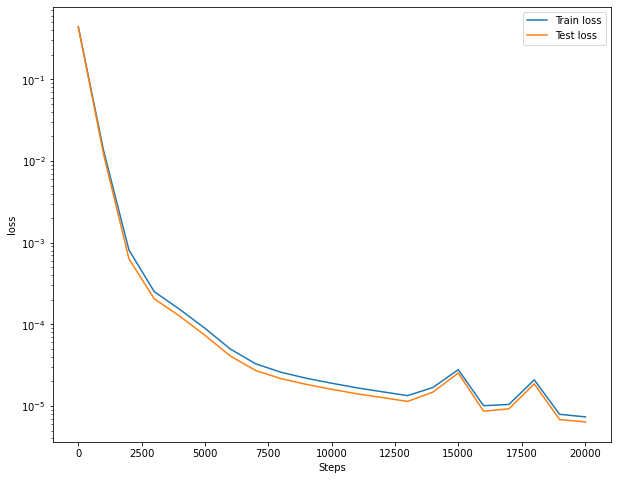

In [7]:
plot_loss_history(losshistory)

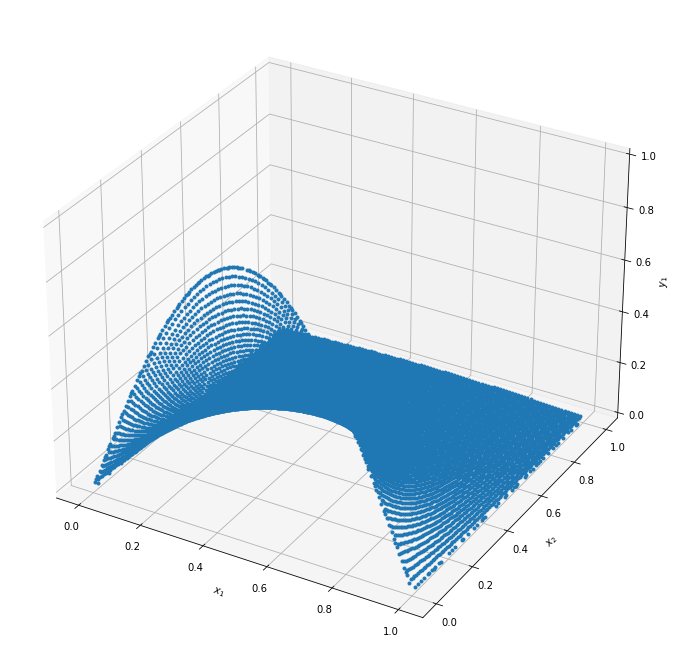

In [8]:
plot_best_state(train_state)

predict

In [9]:
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
# np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

Mean residual: 0.0017451287
L2 relative error: 0.0018966150050654456


<a id="WaveEquation"></a>
## 4 波动方程(Wave Equation)

下面我们讨论波动方程 $$\large u_{tt}-\Delta u = 0, \tag{4.1}$$ 

和非齐次形式 $$\large u_{tt}-\Delta u = f,\tag{4.2}$$ 

的解, 其中给定一定的初始和边界条件. 这里 $t>0,x\in U,U\subset \mathbb{R}^n$。要解的东西是 $\large u:\bar{U} \times[0,\infty) \to \mathbb{R}, u = u(x,t)$。这里拉普拉斯算子是关于空间变量 $x = (x_1,\cdots,x_n)$ 的。另外 $f:U \times[0,\infty) \to \mathbb{R}$ 给定. 通常我们也记 $\Box u := u_{tt} - \Delta u$。



### 4.1 1维情形: d'Alembert公式

**定理1.1 [d'Alembert公式] [一维波动方程的解]** 设 $\large g \in C^2(\mathbb{R}), h \in C^1(\mathbb{R})$，定义

$\large u(x,t) = \frac{1}{2} [g(x+t)+g(x-t)] + \frac{1}{2} \int^{x+t}_{x-t}h(y)dy, \tag{4.3}$ 

则：

（1） $\large u\in C^2(\mathbb{R} \times [0,\infty))$，

（2）$\large u_{tt} - u_{xx} = 0, (x,t) \in \mathbb{R}\times (0,\infty)$，

（3）$\large \lim_{(x,t)\to (x^0,0^+)} u(x,t) = g(x^0), \lim_{(x,t)\to (x^0,0)} u_t(x,t) = h(x^0), \forall x^0 \in \mathbb{R}$。



### 4.2 3维情形: Kirchhoff公式

对 $x\in \mathbb{R}^3, t>0,$ 
$$
\large
\begin{align*}
u(x,t) &= \frac{1}{n\alpha(n)t^{n-1}} \int_{\partial B(x,t)} th(y)+g(y)+Dg(y)\cdot (y-x)dS(y)。\\
\tag{4.4}
\end{align*}
$$
这就是三维情形的**Kirchhoff公式**。

### 4.3 2维情形: Poisson公式

对 $x\in \mathbb{R}^2, t>0,$ 
$$
\large
\begin{align*}
u(x,t) &= \frac{1}{2\pi t} \int_{B(x,t)} \frac{g(y)+th(y)+Dg(y)\cdot (y-x)}{(t^2-|y-x|^2)^{1/2}} dy,\\
\tag{4.5}
\end{align*}
$$
这就是二维情形下的Poisson公式。



### 问题设置
我们考虑一维波动方程的形式:
$$
\large
\begin{aligned}
&u_{tt}(x,t)-100u_{xx}(x,t)=0,(x,t)∈(0,1)\times(0,1), \\ 
&u(0,t)=u(1,t)=0, t∈[0,1],\\
&u(x,0)=\sin(\pi x)+\sin(2\pi x), x∈[0,1],\\
&u_t(x,0)=0, x∈[0,1],\\
\end{aligned}
\tag{4.6}
$$
使用d'Alembert公式求得方程的解是 $$\large u(x,t)=\sin(πx)\cos(10πt)+\sin(2πx)\cos(20πt).$$  

mathematica求解代码

```mathematica
WaveEquation = D[u[x, t], {t, 2}] - 100*D[u[x, t], {x, 2}] == 0;
bc = {u[0, t] == 0, u[1, t] == 0};
ic = {u[x, 0] == Sin[Pi * x] + Sin[2*Pi*x], 
   Derivative[0, 1][u][x, 0] == 0};

sol = DSolve[{WaveEquation, bc, ic}, u[x, t], {x, t}]
(*{{u[x, t] -> (Cos[10 \[Pi] t] + 2 Cos[20 \[Pi] t] Cos[\[Pi] x]) Sin[\[Pi] x]}}*)
```


#### 代码来源
https://github.com/lululxvi/deepxde/blob/master/examples/pinn_forward/wave_1d.py

https://github.com/PredictiveIntelligenceLab/MultiscalePINNs/blob/main/wave1D/wave1D.py


In [10]:
"""Backend supported: tensorflow.compat.v1
Implementation of the wave propagation example in paper https://arxiv.org/abs/2012.10047.
References:
    https://github.com/PredictiveIntelligenceLab/MultiscalePINNs.
"""
import deepxde as dde
import numpy as np

波动方程

$\large u_{tt}(x,t)-100u_{xx}(x,t)=0,(x,t)∈(0,1)\times(0,1)$

In [11]:
C = 10

def pde(x, y):
    dy_tt = dde.grad.hessian(y, x, i=1, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_tt - C ** 2 * dy_xx

geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

边界、初始条件：

bc: $\large u(0,t)=u(1,t)=0, t∈[0,1],$

ic_1: $\large u(x,0)=\sin(\pi x)+\sin(2\pi x), x∈[0,1],$

ic_2: $\large u_t(x,0)=0, x∈[0,1],$

方程的解：

func: $\large u(x,t)=\sin(πx)\cos(10πt)+\sin(2πx)\cos(20πt).$

In [12]:
A = 2

def func(x):
    x, t = np.split(x, 2, axis=1)
    return np.sin(np.pi * x) * np.cos(C * np.pi * t) +\
            np.sin(A * np.pi * x) * np.cos(A * C * np.pi * t)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic_1 = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
# do not use dde.NeumannBC here, since `normal_derivative` does not work with temporal coordinate.
ic_2 = dde.icbc.OperatorBC(
    geomtime,
    lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=1),
    lambda x, _: np.isclose(x[1], 0),
)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic_1, ic_2],
    num_domain=360,
    num_boundary=360,
    num_initial=360,
    solution=func,
    num_test=10000,
)

G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+362=362. 
  warnings.warn("The balance properties of Sobol' points require "


model

如果发生错误：
AttributeError: module 'deepxde.nn.tensorflow' has no attribute 'STMsFFN'

把deepxde后端换成tensorflow_compat_v1

https://deepxde.readthedocs.io/en/latest/modules/deepxde.nn.tensorflow_compat_v1.html#deepxde.nn.tensorflow_compat_v1.msffn.STMsFFN

In [13]:
layer_size = [2] + [100] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.STMsFFN(
    layer_size, activation, initializer, sigmas_x=[1], sigmas_t=[1, 10]
)
net.apply_feature_transform(lambda x: (x - 0.5) * 2 * np.sqrt(3))

model = dde.Model(data, net)

compile

In [14]:
def get_initial_loss(model):
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])
    losshistory, train_state = model.train(0)
    return losshistory.loss_train[0]

initial_losses = get_initial_loss(model)
loss_weights = 5 / initial_losses
model.compile(
    "adam",
    lr=0.001,
    metrics=["l2 relative error"],
    loss_weights=loss_weights,
    decay=("inverse time", 2000, 0.9),
)


Compiling model...
Building Spatio-temporal Multi-scale Fourier Feature Network...


G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.960199 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.22e+06, 1.03e-01, 1.39e+00, 7.29e+01]    [8.41e+05, 1.03e-01, 1.39e+00, 7.29e+01]    [1.11e+00]    

Best model at step 0:
  train loss: 1.22e+06
  test loss: 8.41e+05
  test metric: [1.11e+00]

'train' took 0.565042 s

Compiling model...
'compile' took 1.504811 s



model.train

In [15]:
pde_residual_resampler = dde.callbacks.PDEResidualResampler(period=1)
losshistory, train_state = model.train(
    epochs=10000, callbacks=[pde_residual_resampler], display_every=500
)

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.32e+00, 4.06e+00, 3.43e+00, 3.48e+00]    [1.60e+00, 4.06e+00, 3.43e+00, 3.48e+00]    [1.03e+00]    
500       [3.82e-02, 2.29e-03, 1.11e-03, 5.60e-05]    [1.14e-01, 2.29e-03, 1.11e-03, 5.60e-05]    [9.15e-01]    
1000      [1.94e-02, 1.42e-03, 3.04e-04, 1.08e-04]    [6.50e-02, 1.42e-03, 3.04e-04, 1.08e-04]    [8.82e-01]    
1500      [1.51e-02, 1.18e-03, 1.79e-04, 4.90e-03]    [4.71e-02, 1.18e-03, 1.79e-04, 4.90e-03]    [8.47e-01]    
2000      [1.24e-02, 1.06e-03, 1.32e-04, 7.99e-05]    [3.93e-02, 1.06e-03, 1.32e-04, 7.99e-05]    [8.10e-01]    
2500      [1.11e-02, 9.47e-04, 1.10e-04, 4.05e-05]    [3.51e-02, 9.47e-04, 1.10e-04, 4.05e-05]    [7.73e-01]    
3000      [9.41e-03, 8.96e-04, 9.89e-05, 4.64e-04]    [3.19e-02, 8.96e-04, 9.89e-05, 4.64e-04]    [7.36e-01]    
3500      [9.57e-03, 8.85e-04, 4.16e-05, 5.14e-04] 

saveplot

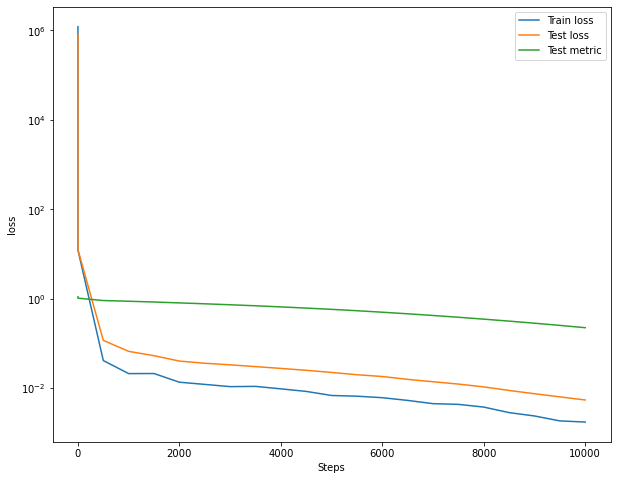

In [16]:
plot_loss_history(losshistory)

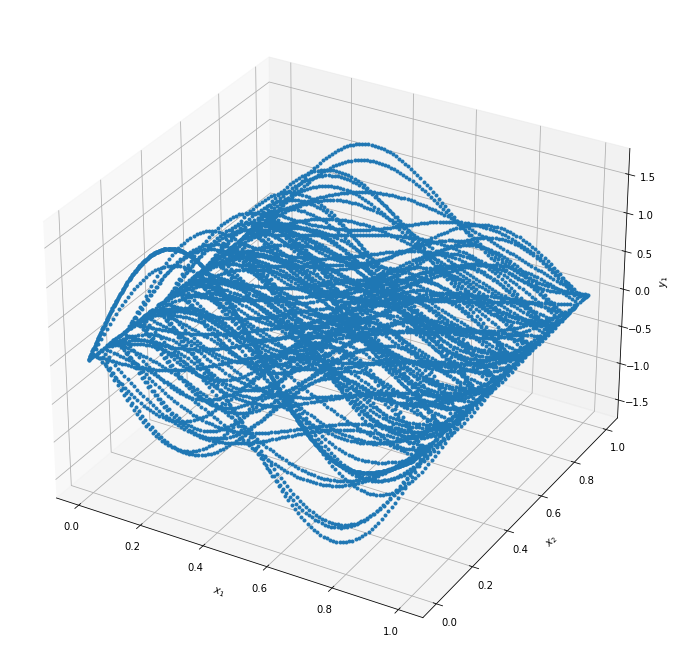

In [17]:
plot_best_state(train_state)


## 扩散方程的逆问题

### 问题设置

我们将求解具有未知参数 $C$ 的扩散方程的逆问题：
$$
\large \frac{\partial y}{\partial t} = C \frac{\partial^2 y}{\partial x^2} - e^{-t}(\sin(\pi x) - \pi^2\sin(\pi x)).\ \ \ \ x\in[-1,1], t\in[0,1]
$$
与初始条件 $\large y(x,0)=\sin⁡(\pi x)$ 

和狄利克雷边界条件 $\large y(−1,t)=y(1,t)=0$.

参考解决方案是 $\large y=e^{−t}sin(\pi x)$.

https://deepxde.readthedocs.io/en/latest/demos/pinn_inverse/diffusion.1d.inverse.html

In [19]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

In [20]:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return (
        dy_t
        - C * dy_xx
        + tf.exp(-x[:, 1:])
        * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    )

def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])


In [21]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


C = dde.Variable(2.0)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)


observe_x = np.vstack((np.linspace(-1, 1, num=10), np.full((10), 1))).T
observe_y = dde.icbc.PointSetBC(observe_x, func(observe_x), component=0)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic, observe_y],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    anchors=observe_x,
    solution=func,
    num_test=10000,
)

G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+42=42. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+22=22. 
  warnings.warn("The balance properties of Sobol' points require "
G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+12=12. 
  warnings.warn("The balance properties of Sobol' points require "


In [22]:
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

In [23]:
model.compile("adam", lr=1e-4, metrics=["l2 relative error"], external_trainable_variables=C)

variable = dde.callbacks.VariableValue(C, period=1000)
losshistory, train_state = model.train(epochs=40000, callbacks=[variable])

Compiling model...
Building feed-forward neural network...
'build' took 0.055620 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.487631 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.52e+01, 5.40e-03, 5.38e-01, 4.52e-02]    [1.58e+01, 5.40e-03, 5.38e-01, 4.52e-02]    [9.20e-01]    
0 [2.00e+00]
1000      [3.14e-01, 4.36e-02, 8.64e-02, 2.30e-02]    [1.93e-01, 4.36e-02, 8.64e-02, 2.30e-02]    [3.84e-01]    
1000 [2.06e+00]
2000      [4.16e-02, 4.33e-02, 5.88e-02, 2.79e-02]    [3.00e-02, 4.33e-02, 5.88e-02, 2.79e-02]    [3.93e-01]    
2000 [2.06e+00]
3000      [1.05e-02, 3.62e-02, 5.45e-02, 2.19e-02]    [1.25e-02, 3.62e-02, 5.45e-02, 2.19e-02]    [3.85e-01]    
3000 [2.05e+00]
4000      [4.89e-03, 2.67e-02, 5.12e-02, 1.71e-02]    [4.93e-03, 2.67e-02, 5.12e-02, 1.71e-02]    [3.85e-01]    
4000 [2.02e+00]
5000      [4.31e-03, 1.38e-02, 3.67e-02, 1.33e-02]    [6.59e-03, 1.38e-02, 3.67e-02, 1.33e-02]    [4.06e-01]    
5000 [1.96e+00]
6000      [2.81e-03, 7.24e-03, 2.23e-02, 1.0

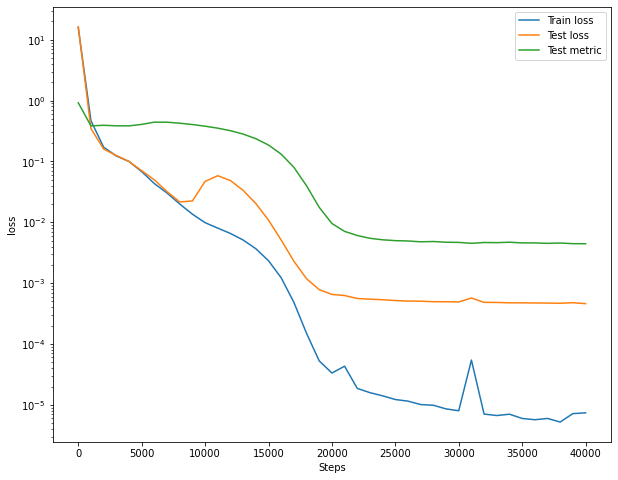

In [24]:
plot_loss_history(losshistory)

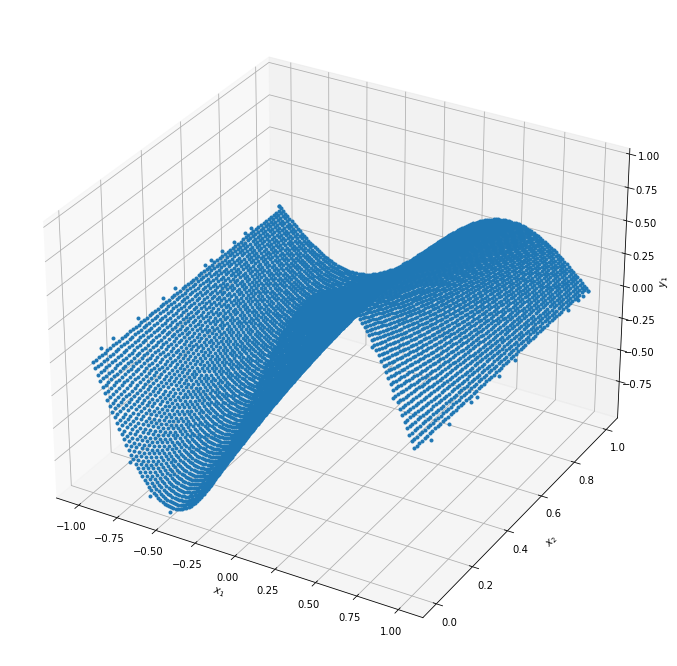

In [25]:
plot_best_state(train_state)

## That's all!